In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


In [228]:
import rl_model
importlib.reload(rl_model)

#import fitting

initial_state_expt_file = os.path.join(git_dir, 'data', '189228-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189236-time-resolved.json')

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = True
MIXING = True

# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE, allow_mixing=MIXING)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

Number of times: 25
0


Time: 1440
reward: -15.720361100490868
[-0.27628032  0.30918931  0.46417551  0.        ]


<IPython.core.display.Javascript object>


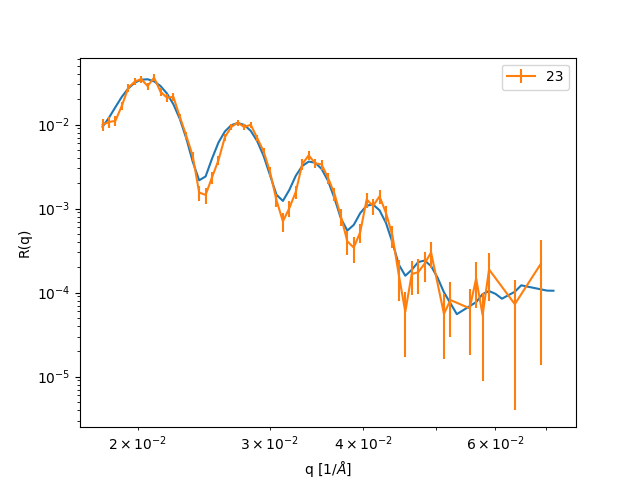

In [229]:
terminated = False
print("Time:", timestamps[env.time_stamp])

#while not terminated: 
for i in range(1):
    #time.sleep(1)

    # choose a random action
    if False:
        action = env.action_space.sample() 
    else:
        action = env.normalized_parameters

    if MIXING:
        action = list(action)
        action.append(0)
        action = np.asarray(action)

    # take the action and get the information from the environment
    new_state, reward, terminated, truncated, info = env.step(action)
    print("reward: %s" % reward)
    # show the current position and reward
    env.render(action=action, reward=reward) 
    env.plot(errors=True)



In [230]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-01-to-06-mixing/",
    name_prefix="rl_model",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if False:
    model.learn(200000, callback=checkpoint_callback)
    model.save('UIUC-01-to-06-SAC-test')
else:
    #model = SAC.load('UIUC-01-to-06-SAC-backward')
    model = SAC.load('UIUC-01-to-06-SAC-mixing')

CPU times: user 23min 40s, sys: 38min 45s, total: 1h 2min 25s
Wall time: 29min 1s


# Compute uncertainties

In [231]:
deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(3, 25, 100)
(3, 25)


In [232]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    chi2.append(env.chi2)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 25
Time 1440 [1.]: -3.70037 [False] -3.70037
Time 1380 [0.9583333]: -1.83812 [False] -5.53849
Time 1320 [0.9166667]: -2.29814 [False] -7.83664
Time 1260 [0.875]: -2.35894 [False] -10.1956
Time 1200 [0.8333333]: -1.57015 [False] -11.7657
Time 1140 [0.7916667]: -2.16598 [False] -13.9317
Time 1080 [0.75]: -1.73949 [False] -15.6712
Time 1020 [0.7083333]: -1.52327 [False] -17.1945
Time 960 [0.6666667]: -1.29518 [False] -18.4896
Time 900 [0.625]: -1.23549 [False] -19.7251
Time 840 [0.5833333]: -1.1457 [False] -20.8708
Time 780 [0.5416667]: -1.36434 [False] -22.2352
Time 720 [0.5]: -1.64542 [False] -23.8806
Time 660 [0.45833334]: -1.2953 [False] -25.1759
Time 600 [0.41666666]: -1.33399 [False] -26.5099
Time 540 [0.375]: -2.54709 [False] -29.057
Time 480 [0.33333334]: -1.67703 [False] -30.734
Time 420 [0.29166666]: -1.86051 [False] -32.5945
Time 360 [0.25]: -1.79701 [False] -34.3915
Time 300 [0.20833333]: -2.49854 [False] -36.8901
Time 240 [0.16666667]: -2.04355 [False] -38.93

<IPython.core.display.Javascript object>


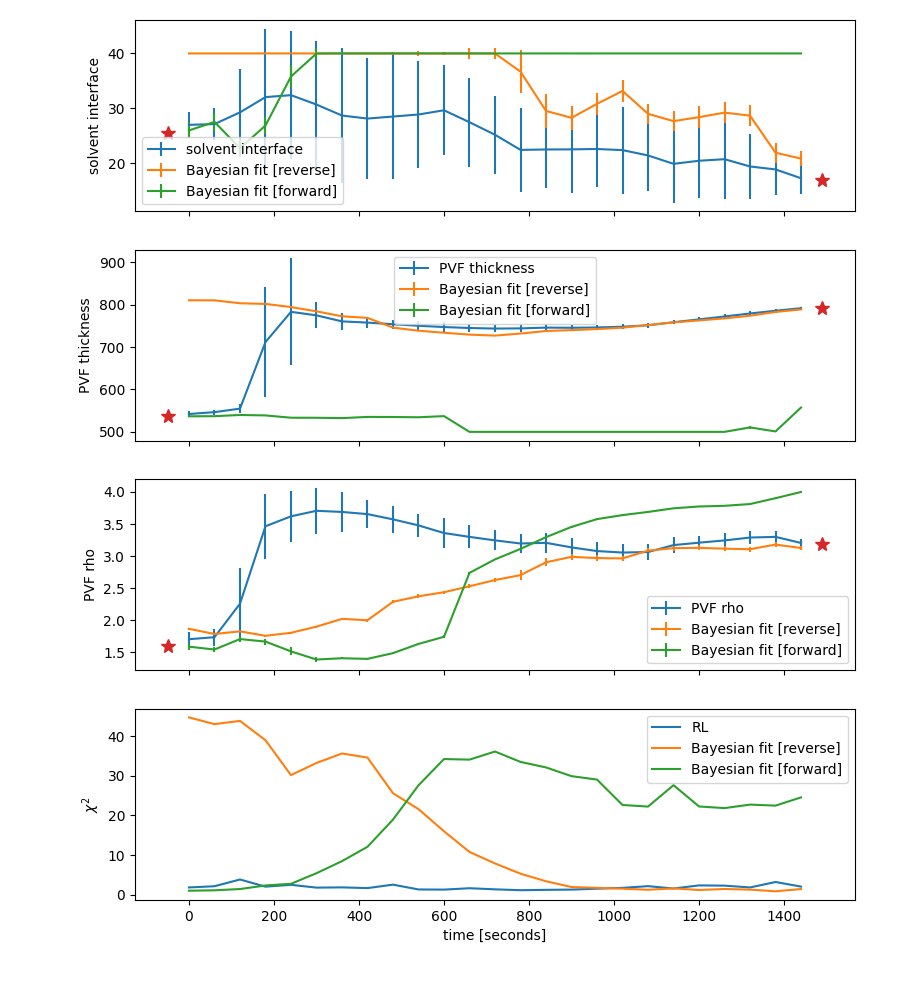

['solvent interface', 'PVF thickness', 'PVF rho']
[   0   60  120  180  240  300  360  420  480  540  600  660  720  780
  840  900  960 1020 1080 1140 1200 1260 1320 1380 1440]


Text(0.5, 0, 'time [seconds]')

In [233]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T
errors = errs.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189236-bayes-forward.json')) as fd:
    bayes_fits_fwd = json.load(fd)
with open(os.path.join(git_dir, 'data', '189236-bayes-backward.json')) as fd:
    bayes_fits = json.load(fd)

if REVERSE:
    t_start = times[0]+50
    t_end = -50
else:
    t_end = times[-1]+50
    t_start = -50

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [reverse]')

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [forward]')
    
    plt.plot([t_start, t_end], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(times, chi2, label = 'RL')
print(timestamps)
plt.plot(timestamps, bayes_fits['chi2'], label = 'Bayesian fit [reverse]')
plt.plot(timestamps, bayes_fits_fwd['chi2'], label = 'Bayesian fit [forward]')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

Number of times: 25


<IPython.core.display.Javascript object>


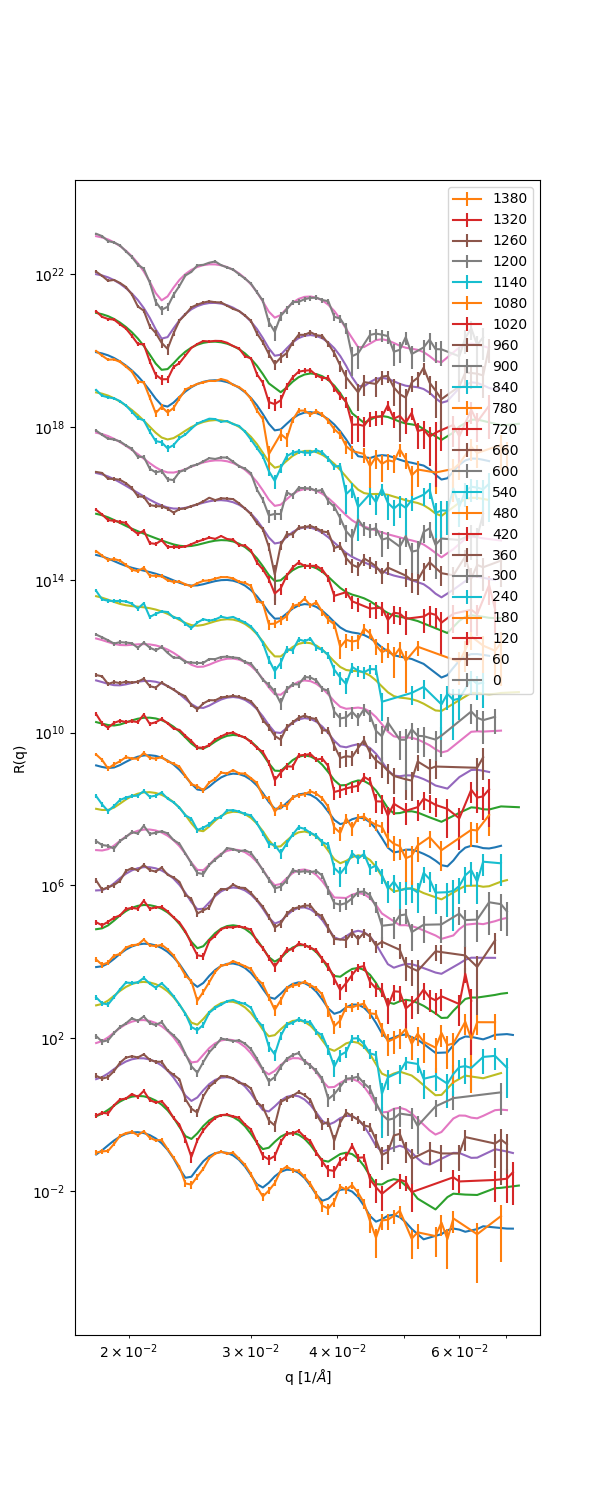

In [235]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=times[i])


<IPython.core.display.Javascript object>


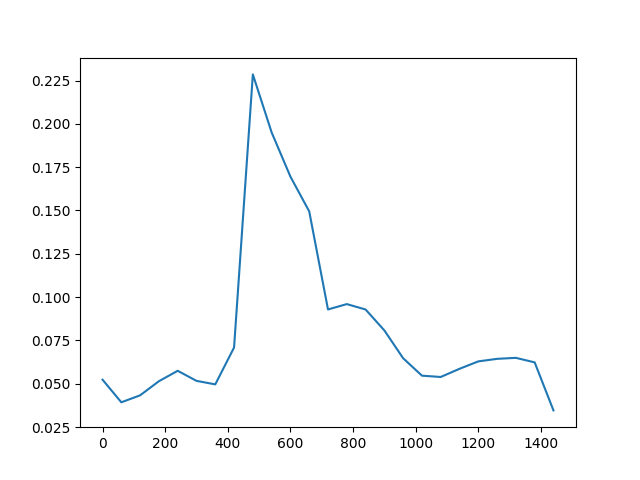

In [217]:
fig = plt.subplots(dpi=100, )
mixing = (actions[:,-1]+1)/2
plt.plot(times,mixing)